In [336]:
import pickle
import pandas as pd
import numpy as np

import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
import re
import string
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation

# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.decomposition import NMF
# nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/noah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/noah/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Using NLTK

In [338]:
df = pd.read_pickle('movie_scripts_df')

In [339]:
df.head()

,names,texts
0,Hellraiser-Hellseeker,\n\n\n HELLRAISER: HELLSEEKER\n...
1,Screa,\n \n ...
2,Lord-of-Illusions,"\n\n\n\n""Lord of Illusions"" -- by Clive Barker..."
3,Dawn-of-the-Dead,\nDAWN OF\nTHE DEAD\n(The working draft 1977)\...
4,Blade-II,"\n""BLADE II"" -- by David Goyer\n\n"


# Cleaning

In [ ]:
print(df.texts.iloc[2])

In [14]:
type(stop_words) # need to add look, see, back

list

In [341]:
for i in ['look', 'see', 'back']:
    stop_words.append(i)

In [ ]:
## trying only nouns

## preprocessing function

In [37]:
def preprocessing(text):
    
    # replace spaces, returns, punctuation
    clean_text = re.sub('\w[A-Z]+\w', '', text) 
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', clean_text)
    clean_text = clean_text.lower().replace('   ', '').replace('\n', ' ')
    
    # tokenize
    tokens = [t for t in clean_text.split()]
#     tokens = word_tokenize(clean_text)
    
    # lemmatize
    lem_tokens = [WordNetLemmatizer().lemmatize(t) for t in tokens]
    
    # remove stopwords
#     clean_tokens = [token for token in lem_tokens if token not in stopwords.words('english')]
    clean_tokens = [token for token in lem_tokens if token not in stop_words]

    return clean_tokens

                        
                        
# text = df.texts[0]
# print(preprocessing(text))                 

In [ ]:
# words = [x.lower() for x in re.findall(r"[\w\@\#\'\&\]\*\-\/\[\=\;]+",raw_text_clean

In [354]:
def preprocessing_only_nouns(text):
    
    # replace spaces, returns, punctuation
    clean_text = re.sub('\w[A-Z]+\w', '', text) 
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)
    clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', clean_text)
    clean_text = clean_text.lower().replace('   ', '').replace('\n', ' ')
    
    # tokenize only nouns
    clean_text_nouns = [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(clean_text)) if pos[0] == 'N']
    
    # lemmatize
    lem_tokens = [WordNetLemmatizer().lemmatize(t) for t in clean_text_nouns]
    
    # remove stopwords
    clean_tokens_nouns = [token for token in lem_tokens if token not in stop_words]

    return clean_tokens_nouns

## now apply cleaner functions to all texts in column

In [356]:
df['tokens'] = df['texts'].apply(lambda x: preprocessing(x))

df['tokens_nouns'] = df['texts'].apply(lambda x: preprocessing_only_nouns(x))

df.head()

,names,texts,tokens,tokens_nouns
0,Hellraiser-Hellseeker,\n\n\n HELLRAISER: HELLSEEKER\n...,"[written, carl, dupre, passenger, window, tree...","[carl, dupre, passenger, window, tree, twenty,..."
1,Screa,\n \n ...,"[kevin, williamson, rewrite, july, hand, reach...","[kevin, july, hand, receiver, face, girl, sixt..."
2,Lord-of-Illusions,"\n\n\n\n""Lord of Illusions"" -- by Clive Barker...","[lord, illusion, clive, barker, credit, run, f...","[lord, illusion, barker, credit, sequence, col..."
3,Dawn-of-the-Dead,\nDAWN OF\nTHE DEAD\n(The working draft 1977)\...,"[working, draft, george, romero, face, young, ...","[draft, george, romero, face, woman, credit, w..."
4,Blade-II,"\n""BLADE II"" -- by David Goyer\n\n","[ii, david, goyer]","[ii, david, goyer]"


In [392]:
df.tokens_nouns.iloc[2][:100]

['mulholland', 'drive', 'screenplay', 'l', 'h', 'l', 'r', 'e', 'l', 'hl', 'r', 'e', 'darkness', 'sound', 'freeway', 'traffic', 'sound', 'carits', 'headlight', 'oleander', 'bush', 'limb', 'eucalyptus', 'tree', 'headlight', 'street', 'sign', 'word', 'sign', 'car', 'move', 'sign', 'word', 'fall', 'darkness', 'caran', 'cadillac', 'limousine', 'way', 'mulholland', 'drive', 'darkness', 'hollywood', 'hill', 'one', 'road', 'car', 'men', 'suit', 'seat', 'dark', 'woman', 'sits', 'door', 'darkness', 'something', 'car', 'side', 'road', 'stop', 'car', 'stopshalf', 'half', 'road', 'blind', 'men', 'woman', 'car', 'carsa', 'model', 'sedan', 'blind', 'curve', 'view', 'cadillac', 'car', 'teenager', 'girl', 'sunroof', 'sedan', 'hair', 'car', 'speed', 'lane', 'mulholland', 'drive', 'driver', 'seat', 'pistol', 'silencer', 'woman', 'man', 'car', 'woman', 'seat', 'door', 'handle', 'man', 'car', 'woman']

## Remove scripts that are too short

In [358]:
for i,x in enumerate(df.tokens):
#     print(i,len(x))
    if len(x) < 8000:
        df.drop(index=i,inplace=True)

In [ ]:
for i,x in enumerate(df.tokens_nouns):
#     print(i,len(x))
    if len(x) < 8000:
        df.drop(index=i,inplace=True)

In [361]:
df.shape

(125, 4)

## Making column of strings for vectorization

In [363]:
df['token_strings'] = df.tokens.apply(lambda x: ' '.join(x))

df['token_nouns_strings'] = df.tokens_nouns.apply(lambda x: ' '.join(x))

In [364]:
df.head()

,names,texts,tokens,tokens_nouns,token_strings,token_nouns_strings
3,Dawn-of-the-Dead,\nDAWN OF\nTHE DEAD\n(The working draft 1977)\...,"[working, draft, george, romero, face, young, ...","[draft, george, romero, face, woman, credit, w...",working draft george romero face young woman a...,draft george romero face woman credit woman fa...
5,Gremlins-2,\n \n \n ...,"[written, charlie, haas, revised, crowded, chi...","[charlie, haas, street, rand, peltzer, mogwai,...",written charlie haas revised crowded chinatown...,charlie haas street rand peltzer mogwai stair ...
6,Mulholland-Drive,\n\n\n\nMulholland Drive Screenplay\n\n\n\n\t\...,"[mulholland, drive, screenplay, u, l, h, l, l,...","[mulholland, drive, screenplay, l, h, l, r, e,...",mulholland drive screenplay u l h l l n r v e ...,mulholland drive screenplay l h l r e l hl r e...
7,What-Lies-Benea,\n\n\n WHAT LIES BENEATH\...,"[clark, gregg, june, moving, murky, hazedark, ...","[clark, gregg, june, hazedark, blue, green, sh...",clark gregg june moving murky hazedark blue gr...,clark gregg june hazedark blue green shaft pur...
8,House-of-1000-Corpses,"\n ""HOUSE OF 1...","[written, r, w, zombie, revised, adancing, aro...","[r, w, zombie, movie, monster, frame, barrel, ...",written r w zombie revised adancing around gra...,r w zombie movie monster frame barrel shotgun ...


Fixing script names

In [434]:
df.names[120:]

150         Alien-3
152      Thing,-The
153    Suspect-Zero
154    Lost-Highway
155          Misery
Name: names, dtype: object

In [433]:
# df.names = df.names.replace('Silver-Bulle', 'Silver-Bullet')

## Pickling for posterity

In [435]:
# Pickling

# filename = 'data_for_vectorization'
# outfile = open(filename,'wb')
# pickle.dump(df,outfile)
# outfile.close()

Open our data here if running notebook fresh

In [20]:
# df = pd.read_pickle('data_for_vectorization')

## Word frequencies

In [ ]:
freq = nltk.FreqDist(df['tokens'][0])

for key,val in freq.items():

    print (str(key) + ':' + str(val))

In [45]:
def word_freq(text, num_words=200, freq_threshold=1000): # text is column of df
    """ 
    Returns most common words across all entries in column.
    -------------------------------------------------------
    Inputs: 
    num_words amount of returned words.
    freq_threshold: cutoff for top appearing words
    
    """
    all_words_list = []
    for movie_script in text:
        for word in movie_script:
            all_words_list.append(word)
    
    top_words = Counter(all_words_list).most_common(num_words)
    
    results_list = []
    for pair in top_words:
        if pair[1] > freq_threshold:
            results_list.append(pair)
    return results_list, all_words_list

In [46]:
word_freqs, all_words_list = word_freq(df.tokens)


In [47]:
all_words_string = ' '.join(all_words_list)

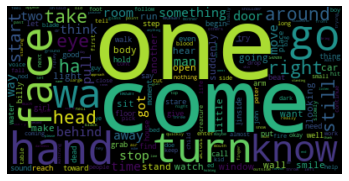

In [48]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(all_words_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorizing

## CV

In [ ]:
### example

cv1 = CountVectorizer(stop_words='english')
text_cv = cv1.fit_transform(X_train)


pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

In [382]:
cv = CountVectorizer(stop_words='english', max_features = 10000)
text_cv = cv.fit_transform(df.token_strings)
cv_df = pd.DataFrame(text_cv.toarray(), columns=cv.get_feature_names()) # returns counts

nouns_cv_array = cv.fit_transform(df.token_strings)
cv_nouns_df = pd.DataFrame(nouns_cv_array.toarray(), columns=cv.get_feature_names())

In [367]:
cv_df.head()

,aa,aand,aappears,aaron,aat,aback,abandon,abandoned,abbey,abbot,...,zero,zip,zipper,zippo,zoe,zombie,zone,zoo,zoom,zowie
0,2,0,0,0,0,0,2,2,0,0,...,2,1,0,0,0,236,1,0,5,0
1,0,2,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,2,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,2,0,0,0,0


### Preparing CV for LDA viz outside jupyter lab

In [368]:
filename = 'cv' # 3rd arg
outfile = open(filename,'wb')
pickle.dump(cv,outfile)
outfile.close()

In [369]:
filename = 'text_cv' # 2nd arg
outfile = open(filename,'wb')
pickle.dump(text_cv,outfile)
outfile.close()

In [370]:
lda_cv = LatentDirichletAllocation(n_components=20, random_state=0)
lda_cv.fit(text_cv)

LatentDirichletAllocation(n_components=20, random_state=0)

In [371]:
filename = 'lda_cv' # 1st arg
outfile = open(filename,'wb')
pickle.dump(lda_cv,outfile)
outfile.close()

In [372]:
filename = 'cv_df'
outfile = open(filename,'wb')
pickle.dump(cv_df,outfile)
outfile.close()

In [383]:
# pickling nouns

filename = 'nouns_cv_array'
outfile = open(filename,'wb')
pickle.dump(nouns_cv_array,outfile)
outfile.close()

filename = 'cv_nouns_df'
outfile = open(filename,'wb')
pickle.dump(cv_nouns_df,outfile)
outfile.close()


## TF IDF

In [393]:
text = df.token_strings
nouns = df.token_nouns_strings

tfidf_nouns = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', max_features = 100000) # could limit max
tfidf1 = TfidfVectorizer(stop_words='english')
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', max_features = 100000) # could limit max


# arg 2 for pyLDAvis
tfidf_nouns_array = tfidf_nouns.fit_transform(nouns)
text_tfidf1 = tfidf1.fit_transform(text)
text_tfidf2 = tfidf2.fit_transform(text)


tfidf_nouns_df = pd.DataFrame(tfidf_nouns_array.toarray(), columns=tfidf2.get_feature_names())
tfidf1_df = pd.DataFrame(text_tfidf1.toarray(), columns=tfidf1.get_feature_names())
tfidf2_df = pd.DataFrame(text_tfidf2.toarray(), columns=tfidf2.get_feature_names())



In [379]:
tfidf_nouns_df.head()

,aa,aaaah,aah,aand,aappears,aapproaches,aaron,aaron nod,aat,ab,...,zombie wheel,zombie window,zone,zoo,zoo dr,zoo thing,zoom,zoom face,½g,½ï
0,0.009769,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018483,0.018483,0.010537,0.0,0.0,0.0,0.011082,0.0,0.000000,0.000000
1,0.000000,0.0,0.024124,0.013979,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.013752,0.0,0.0,0.0,0.000000,0.0,0.024124,0.022659
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.000000,0.016023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


### Preparing TFIDF for LDAviz

In [375]:
# Pickling tfidf2

filename = 'tfidf2'
outfile = open(filename,'wb')
pickle.dump(tfidf2,outfile)
outfile.close()




In [376]:
# Pickling text_tfidf2; 3rd arg

filename = 'text_tfidf2'
outfile = open(filename,'wb')
pickle.dump(text_tfidf2,outfile)
outfile.close()

filename = 'tfidf2_df'
outfile = open(filename,'wb')
pickle.dump(tfidf2_df,outfile)
outfile.close()

In [394]:
# Pickling tfidf noun

filename = 'tfidf_nouns_array'
outfile = open(filename,'wb')
pickle.dump(tfidf_nouns_array,outfile)
outfile.close()


filename = 'tfidf_nouns_df'
outfile = open(filename,'wb')
pickle.dump(tfidf_nouns_df,outfile)
outfile.close()
